# Van Der Pol oscillator physics-informed neural network (PINN)

Code for Van der Pol oscillator based on Hubert Baty's implementation, Github link below: \\

* https://github.com/hubertbaty/PINNS-EDO2

### Imports

---

In [78]:
from PIL import Image
from scipy.integrate import solve_ivp
from __future__ import division, print_function

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import time

### Range Kutta and Neural Network Definition

---[link text](https://)

In [73]:
def runge_kutta4(func, r, t, omega, nu, h):
    """
    Runge-Kutta 4 method for solving 1st order differential equations

    Usage: xNew = rk4(func, r, t, h)

    Given a function  f(x, t, h) = dx/dt and initial starting
    conditions for x, rk4() returns the next values of x.
    func:  user defined function for the 1st order differential equations
    r: dependent variable(s)
    t: independent variable(s)
    h: independent variable step value
    """
    k1 = h*func(r, t, omega, nu)
    k2 = h*func(r+0.5*k1, t+0.5*h, omega, nu)
    k3 = h*func(r+0.5*k2, t+0.5*h, omega, nu)
    k4 = h*func(r+k3, t+h, omega, nu)
    return (k1 + 2*k2 + 2*k3 + k4)/6

def pendule_Function(r, t, omega, nu):
    """ vectorized function for the pendule """
    x = r[0]
    v = r[1]
    fx = v
    fv = -omega**2 * x  +  nu*(1 - x**2)*v
    return np.array([fx,fv], float)

class FCN(nn.Module):
    "Defines a connected network"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


### Exact Solution and Training Data

---

<function matplotlib.pyplot.show(close=None, block=None)>

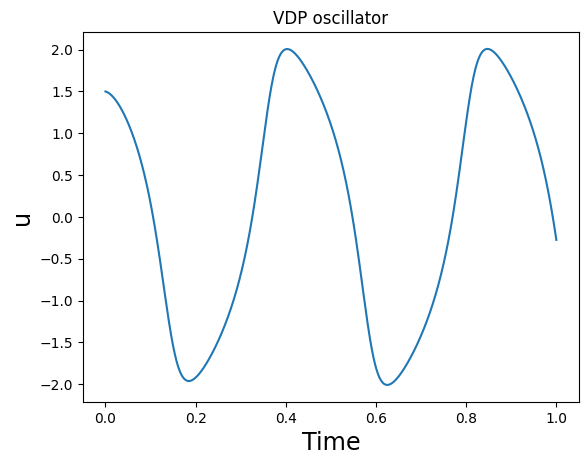

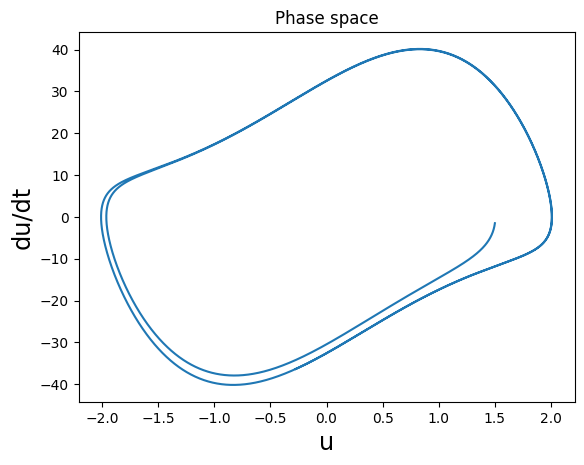

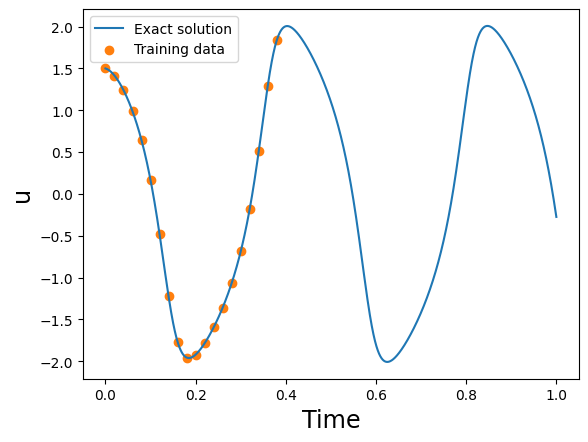

In [65]:
# We define the time step for RK4 numerical integration ... is important also for visualization
nSteps=10000
#Define omega0 and nu parameters .................
w0 = 15.
nu=15.        # This is epsilon * w0 (nu = 5 -> epsilon = 1/3) ...................

# We integrate between tMin and tMax .............
tMin,tMax = 0.0,1
tStep = (tMax-tMin)/nSteps

tPoints = np.arange(tMin, tMax, tStep)
xPoints,vPoints = [],[]

# set initial conditions on the state variables ..........
x0,v0 = 1.5,-1.5
r = np.array([x0,v0], float)

# solve for the time evolution for the true solution obtained with Runge-kutta of order 4 integration
for t in tPoints:
    xPoints += [r[0]]
    vPoints += [r[1]]
    r += runge_kutta4(pendule_Function, r, t, w0, nu, tStep)

# plot displacement vs time  (true solution)
fig1 = plt.figure(1)
plt.plot(tPoints, xPoints)
plt.xlabel("t")
plt.ylabel("u")
plt.xlabel("Time",fontsize="xx-large")
plt.ylabel("u",fontsize="xx-large")
plt.title("VDP oscillator")


x=torch.Tensor(tPoints).view(-1,1)
y=torch.Tensor(xPoints).view(-1,1)

# We select only some points (one over 10 for example) for future comparison with true solution
x = x[::10]
y = y[::10, :]

# We select a very few data points to be used in the normal Neural netwok -> training data ...
x_data=x[0:400:20]
y_data=y[0:400:20]

# plot the phase space (true solution)
fig2 = plt.figure(2)
plt.plot(xPoints, vPoints)
plt.xlabel("u",fontsize="xx-large")
plt.ylabel("du/dt",fontsize="xx-large")
plt.title("Phase space")

# We plot data of the true solution and the training data .............................
plt.figure()
plt.plot(tPoints, xPoints, label="Exact solution")
plt.xlabel("Time",fontsize="xx-large")
plt.ylabel("u",fontsize="xx-large")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show


### Normal neural network

---

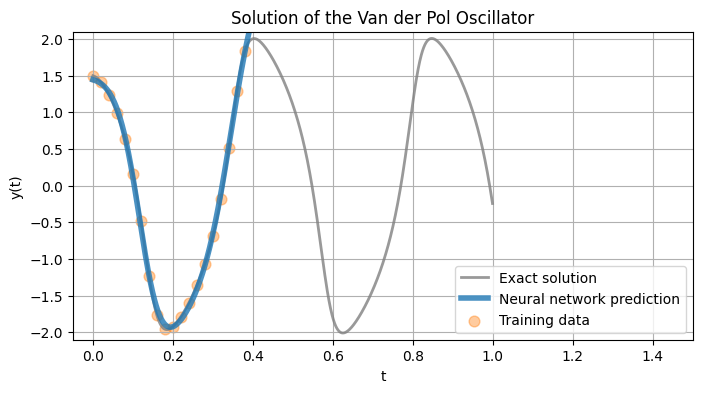

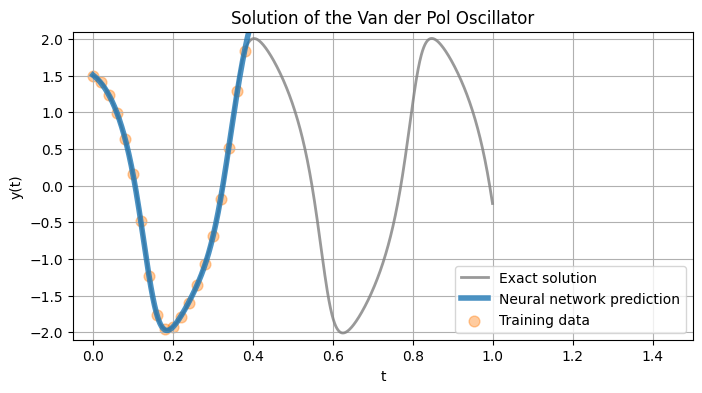

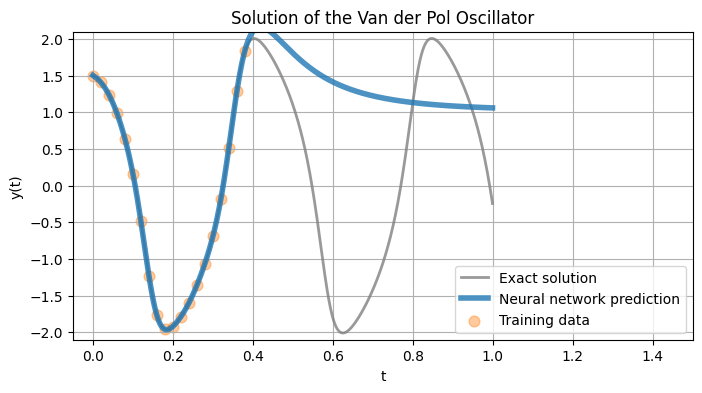

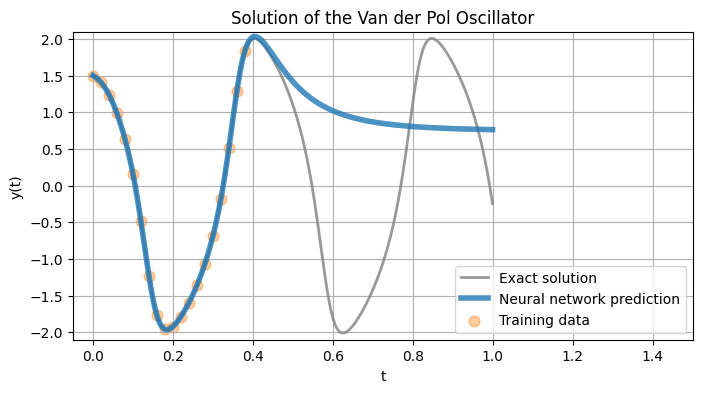

In [66]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))

    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")

    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")

    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')

    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    plt.legend(loc='lower right')
    plt.xlim(-0.05, 1.5)
    plt.ylim(-2.1, 2.1)
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.title('Solution of the Van der Pol Oscillator')
    plt.grid(True)

# We train a standard neural network to fit training data (one must choos lr and number of
# layers, number of neurons per layer) ....................................................
torch.manual_seed(127)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(16000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error to define Loss on data ......
    loss.backward()
    optimizer.step()

    # plot the result as training progresses ..............................................
    if (i+1) % 100 == 0:
        yh = model(x).detach()
        plot_result(x,y,x_data,y_data,yh)
        if (i+1) % 4000 == 0: plt.show()
        else: plt.close("all")


### PINN

---

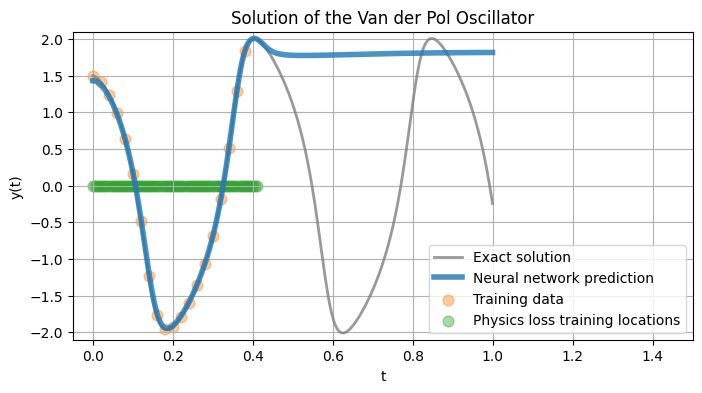

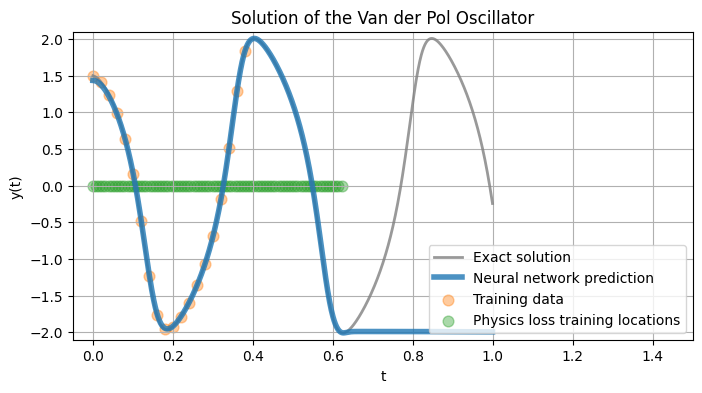

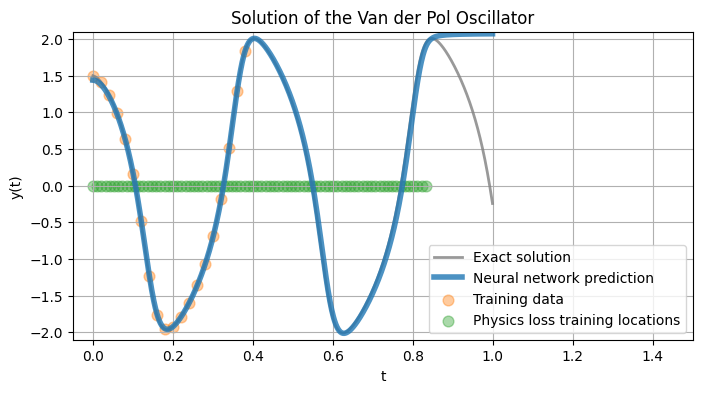

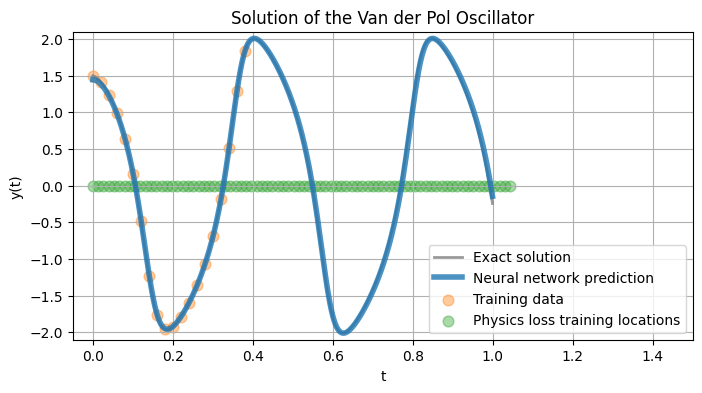

In [67]:
ww=w0
torch.manual_seed(125)
model = FCN(1,1,42,4)

optimizer = torch.optim.Adam(model.parameters(),lr=7e-4)
files = []
loss1_history = []
loss2_history = []
loss_history = []
mse_history = []

# Training
start_train_time = time.time()  # Record the start time for training

for i in range(50000):
    # the range of colocation points is increasing with a moving right boundary .....
    lim=0.2 + np.minimum(1.3*i/74000.,1.3)
    x_physics = torch.linspace(0.,lim,80).view(-1,1).requires_grad_(True)#
    optimizer.zero_grad()

    # compute the first part of the "data loss" .....
    yh = model(x_data)
    loss1 = 1*torch.mean((yh-y_data)**2)  # use mean squared error (the weight is taken to be 1)

    # compute the "physics loss" with enforcing the initial data ........................
    yhp = model(x_physics)
    # compute first and second derivatives by automatic differentiation .........................
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2

    # second part of loss1 .............
    loss1 = loss1 + 0.1*torch.max((dx[0])**2)

    # computes the equation residual ........................................
    physics = (dx2 + ww**2*yhp - nu*(1 - yhp*yhp)*dx)   # This is the equation ................
    loss2 = (1e-4)*torch.mean(physics**2)    # Loss on physics with a chosen weight ..........
    yhpp=model(x)
    mse=torch.mean((yhpp-y)**2)   # compute mean square error using exact solution ............

    # backpropagate the total loss .......................................................
    loss = loss1 + loss2  # add two loss terms together ..................................
    loss.backward()
    optimizer.step()

    # plot the result as training progresses ...............................
    if (i+1) % 100 == 0:
        loss1_history.append(loss1.detach())
        loss2_history.append(loss2.detach())
        loss_history.append(loss.detach())

        yh = model(x).detach()
        xp = x_physics.detach()

        yhpp=model(x)
        mse=torch.mean((yhpp-y)**2)   # compute mean square error using exact solution .....
        mse_history.append(mse.detach())


        plot_result(x,y,x_data,y_data,yh,xp)

        if (i+1) % 12000 == 0: plt.show()
        else: plt.close("all")

end_train_time = time.time()  # Record the end time for training
train_time = end_train_time - start_train_time  # Calculate the training time

# Define evaluation time points for inference
t_eval_inference = np.linspace(0, 1.5, 10000)
t_data = torch.tensor(t_eval_inference.reshape(-1, 1)).float()

# Inference
start_inference_time = time.time()  # Record the start time for inference

with torch.no_grad():
    y_pred_inference = model(t_data)

end_inference_time = time.time()  # Record the end time for inference
inference_time = end_inference_time - start_inference_time  # Calculate the inference time



### Training Time and Inference Time

---

In [70]:
print(train_time)
print(inference_time)

408.18500447273254
0.010114669799804688


### Numerical Solution via solve_ivp

---

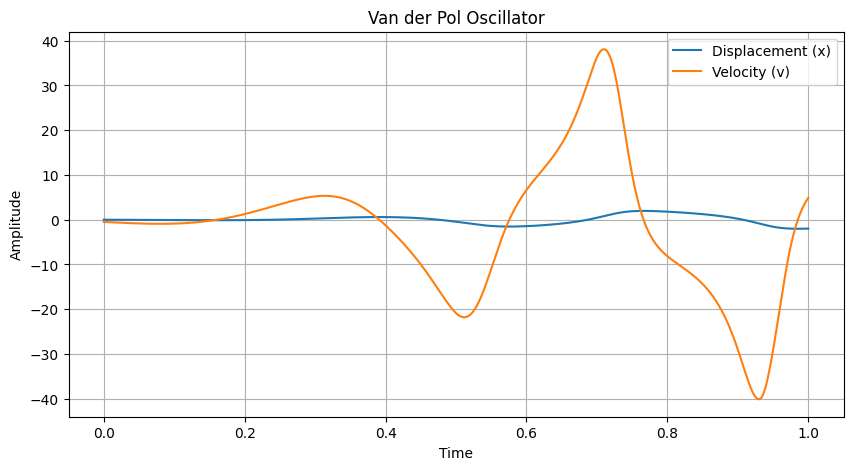

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

# Define the Van der Pol oscillator dynamics
def vdp_oscillator(t, y, omega, nu):
    x, v = y
    dxdt = v
    dvdt = -omega**2 * x + nu * (1 - x**2) * v
    return [dxdt, dvdt]

# Parameter definitions
omega = 15.0
nu = 15.0

t_span = (0.0, 1.0) # Time span for integration
y0 = [0.0, -0.5]  # Initial conditions

# Integrate the VDP oscillator using solve_ivp
start_train_time = time.time()
sol = solve_ivp(vdp_oscillator, t_span, y0, args=(omega, nu), dense_output=True)
end_train_time = time.time()
ode_train_time = end_train_time - start_train_time

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t_eval, y_eval[0], label='Displacement (x)')
plt.plot(t_eval, y_eval[1], label='Velocity (v)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Van der Pol Oscillator')
plt.legend()

plt.grid(True)
plt.show()

### Time of Numerical Solver for Comparison

---

In [71]:
print(ode_train_time)

0.014997243881225586
